<a href="https://colab.research.google.com/github/AlmTechSoftware/piper/blob/main/training_data/research/feynman_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prerequisites

## Dataset download from temporary 0x0.st

In [1]:
!curl http://0x0.st/HLtv.zip > dataset.zip
!rm -r dataset
!unzip dataset.zip -d dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 12.1M  100 12.1M    0     0  6931k      0  0:00:01  0:00:01 --:--:-- 6932k
Archive:  dataset.zip
 extracting: dataset/README.dataset.txt  
 extracting: dataset/README.roboflow.txt  
   creating: dataset/test/
 extracting: dataset/test/Adam-still_jpeg.rf.90fbaea30ed3e09fd7fda5aa92ea6a68.jpg  
 extracting: dataset/test/Adam-still_jpeg.rf.90fbaea30ed3e09fd7fda5aa92ea6a68_mask.png  
 extracting: dataset/test/Board_jpg.rf.4d5d6a6f3c89eab87661fa09120877ef.jpg  
 extracting: dataset/test/Board_jpg.rf.4d5d6a6f3c89eab87661fa09120877ef_mask.png  
 extracting: dataset/test/MPC_2_jpg.rf.8263fb9cbb0b86857de4519a380ac872.jpg  
 extracting: dataset/test/MPC_2_jpg.rf.8263fb9cbb0b86857de4519a380ac872_mask.png  
 extracting: dataset/test/_classes.csv  
 extracting: dataset/test/falling_mp4-4_jpg.rf.6ae094b71ea51930490457b2e4125171.jpg  
 extrac

## Dependencies

In [2]:
!pip install  opencv-python \
              scikit-image \
              python-dotenv \
              pycocotools \
              dataclasses-json \
              supervision \
              colored \
              wandb \
              torchvision \
              torchviz -Uq

## WandB login

In [3]:
import wandb
wandb.login()

wandb: Currently logged in as: wych (almtech). Use `wandb login --relogin` to force relogin


True

# Definitions

## Dataset Handler Definition

In [4]:
import os
import numpy as np

from torch.utils.data import Dataset
from torchvision import transforms

from PIL import Image

from glob import glob

class PNGMaskDataset(Dataset):
    def __init__(
        self,
        dataset_dir: str,
    ):
        self.dataset_dir = dataset_dir
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
            ]
        )

        # Example _classes.csv
        """
        Pixel Value, Class
        0, background
        1, sghug
        2, w%
        """

        # Parse _classes.csv
        fh = open(os.path.join(self.dataset_dir, "_classes.csv"))
        lines = fh.readlines()
        fh.close()

        self.classes = map(lambda csv: csv.split(", "), lines)
        self.classes = map(lambda csv: (csv[1], int(csv[0])), self.classes)


        # Load images & masks
        self.mask_files = glob(os.path.join(self.dataset_dir, "*_mask.png"))

        all_files =  glob(os.path.join(self.dataset_dir, "*"))
        self.images = {}
        for mask_file in self.mask_files:
            img_file = mask_file.replace("_mask.png", ".jpg")
            base, ext = os.path.splitext(img_file)

            if img_file in all_files:
                self.images[base] = {
                    "image": img_file,
                    "mask": mask_file,
                }

    def __str__(self):
        return str(self.images)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_info = list(self.images.values())[idx]

        # Load and preprocess the image
        image_path = image_info["image"]
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)

        # Load and preprocess the segmentation mask
        mask_path = image_info["mask"]
        mask = Image.open(mask_path).convert("RGB")
        mask = self.transform(mask)
        mask = mask * 255 # TODO: change color depending on type

        return image, mask

In [5]:
import torchvision.transforms as T
_tensor_pil_transform = T.ToPILImage()

def tensor_to_pil(tensor):
    return _tensor_pil_transform(tensor)

### Example

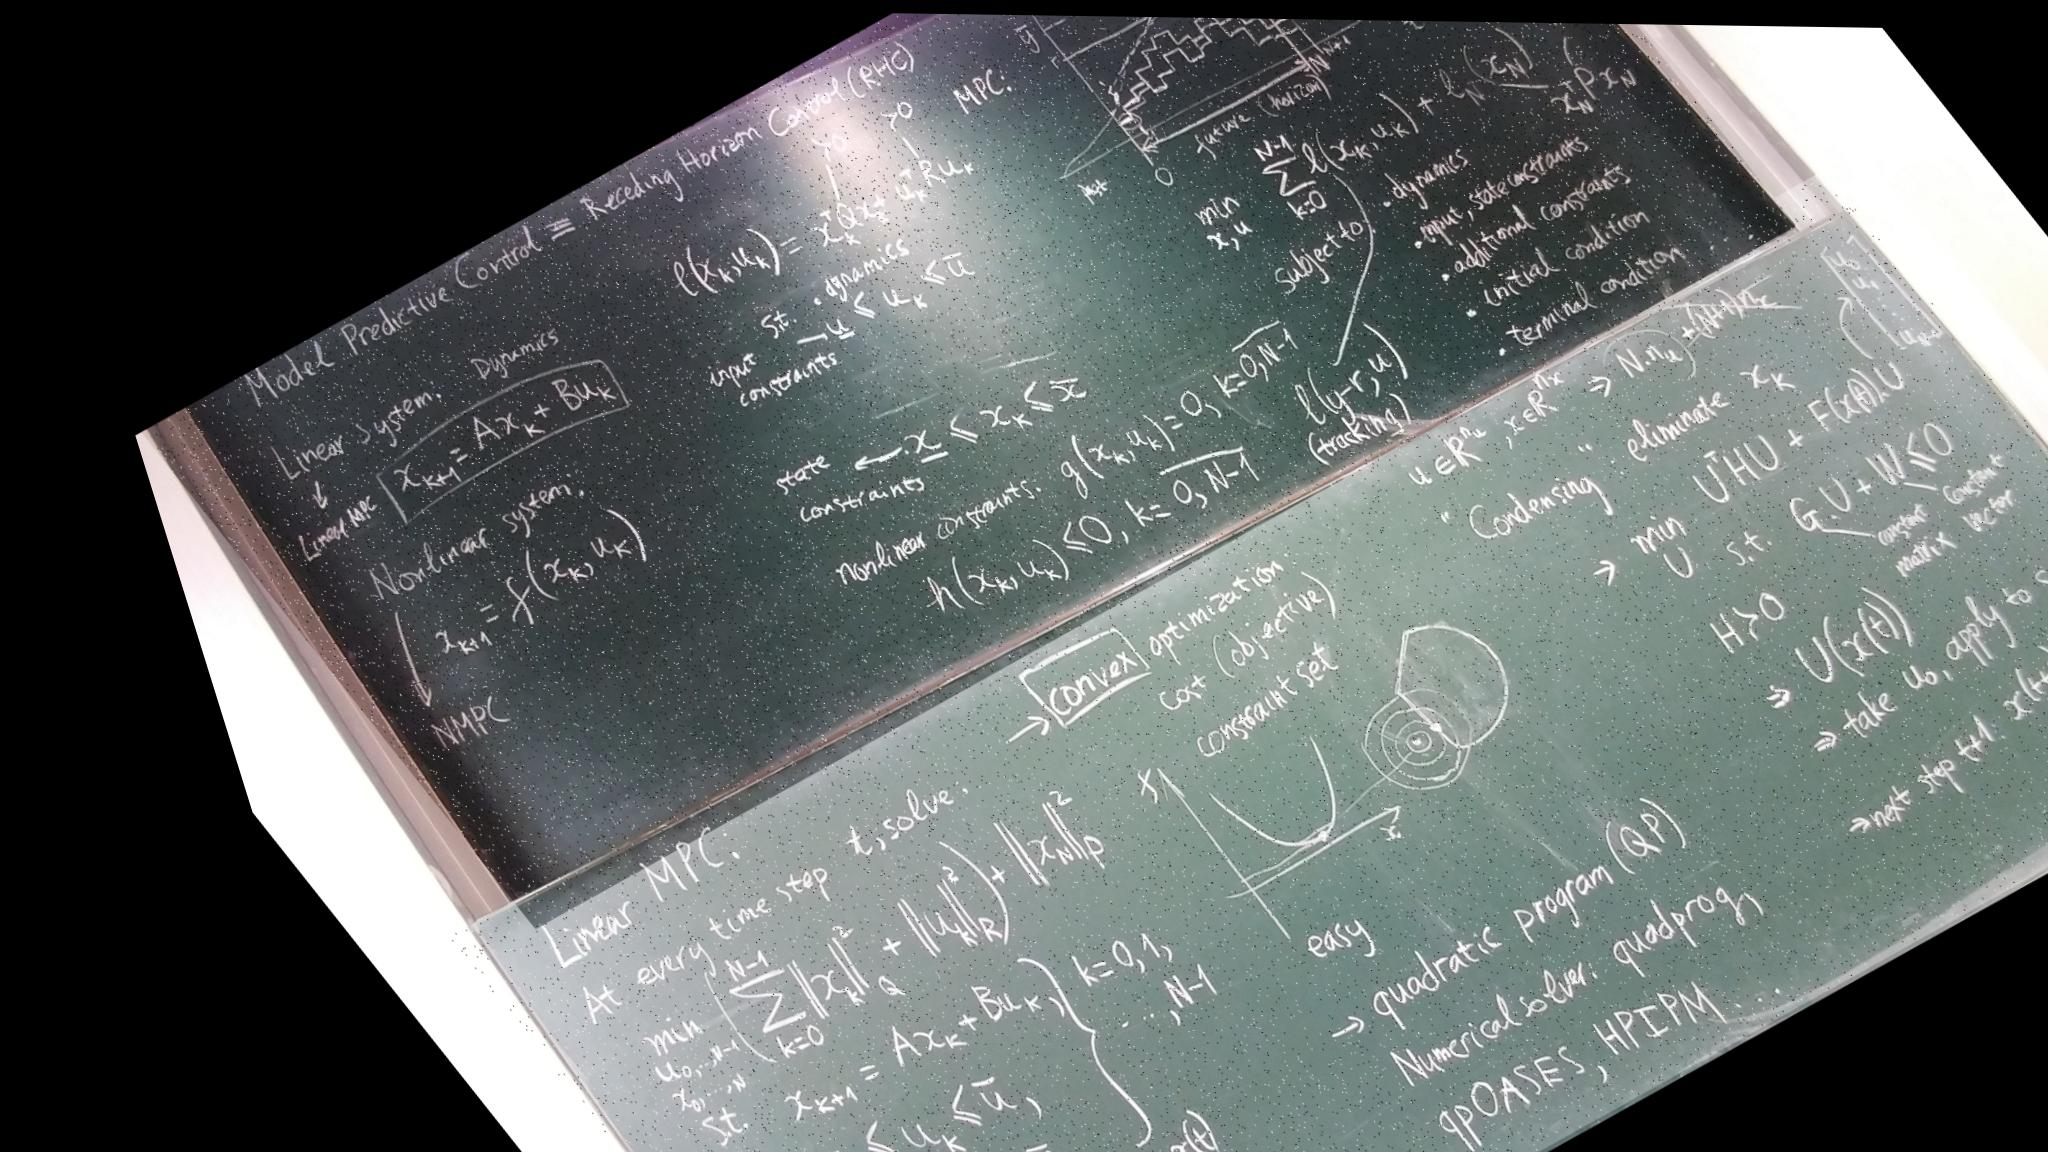

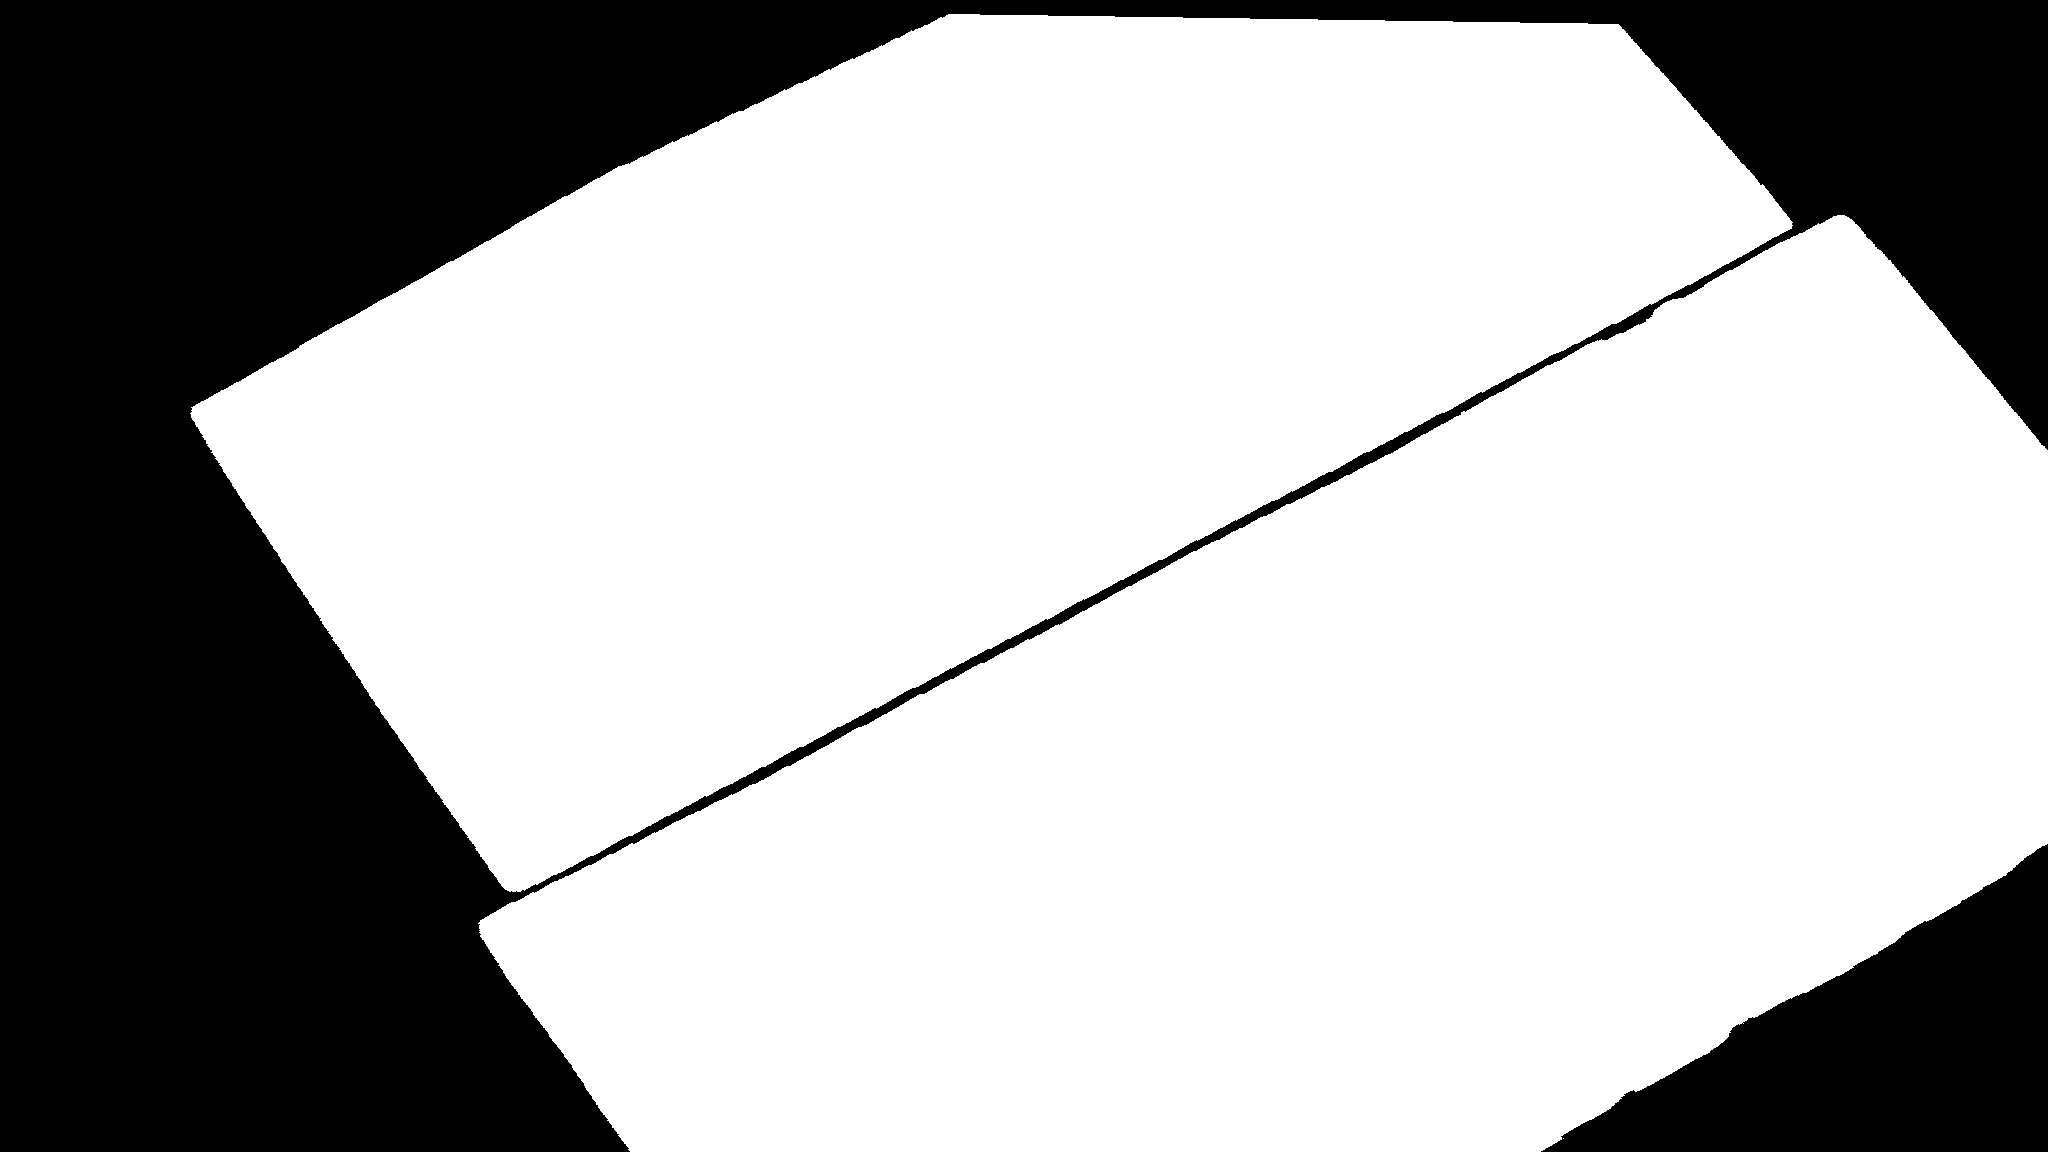

In [6]:
dataset = PNGMaskDataset("dataset/train")

img, mask = dataset[0]

img = tensor_to_pil(img)
mask = tensor_to_pil(mask)

display(img)
display(mask)

del dataset, img, mask

## FeynMAN Model Definition

In [7]:
# Import needed libs

import torch
import torch.nn as nn

In [8]:
class BottleneckBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride: int = 1):
        super(BottleneckBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels // 4, kernel_size=1)
        self.conv2 = nn.Conv2d(out_channels // 4, out_channels // 4, kernel_size=3, stride=stride, padding=1)
        self.conv3 = nn.Conv2d(out_channels // 4, out_channels, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = None

        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x

        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)

        if self.downsample is not None:
            identity = self.downsample(identity)

        x += identity
        x = self.relu(x)
        return x

In [9]:
import torch
import torch.nn as nn

from torch import Tensor

class FeynMAN(nn.Module):
    def __init__(self, num_classes: int):
        super(__class__, self).__init__()
        self.resnet50_backbone = self._build_resnet50()
        self.conv1x1 = nn.Conv2d(2048, num_classes, kernel_size=1)
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1),
            nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1),
            nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1)
        )

    def forward(self, x: Tensor) -> Tensor:
        x = self.resnet50_backbone(x)
        x = self.conv1x1(x)
        x = self.upsample(x)
        return x

    def _build_resnet50(self) -> nn.Module:
        layers = [
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        ]

        block_layers = [3, 4, 6, 3]
        in_channels = 64
        out_channels = [256, 512, 1024, 2048]

        for layer_count, out_channel in zip(block_layers, out_channels):
            layers.append(self._make_layer(in_channels, out_channel, layer_count))
            in_channels = out_channel

        return nn.Sequential(*layers)

    @staticmethod
    def _make_layer(in_channels: int, out_channels: int, blocks: int) -> nn.Module:
        layers = [BottleneckBlock(in_channels, out_channels)]
        for _ in range(1, blocks):
            layers.append(BottleneckBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

# Training

In [10]:
!nvidia-smi && echo "YES YOU CAN TRAIN WITH CUDA!"

Sat Aug 26 20:05:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [11]:
LEARNING_RATE = 0.001
EPOCHS = 100
BATCH_SIZE = 8
DATASET_DIR = "dataset/train/"

In [12]:
from torch.utils.data import DataLoader

import torch
import torch.nn as nn
import torch.optim as optim

def train_model(
    model: nn.Module,
    dataset_dir: str = DATASET_DIR,
    epochs: int = EPOCHS,
    batch_size: int = BATCH_SIZE,
    learning_rate: float = LEARNING_RATE,
    device: torch.device = torch.device("cpu"),
):
    # start a new wandb run to track this script
    wandb.init(
        # set the wandb project where this run will be logged
        project="feynman_2",

        # track hyperparameters and run metadata
        config={
        "learning_rate": learning_rate,
        "epochs": epochs,
        "batch_size": batch_size,
        "architecture": "FeynMAN",
        "dataset": "feynman_v7i",
        }
    )

    # Watch the model for cool weights & biases
    wandb.watch(model)

    criterion = nn.BCELoss() #### TODO: change?
    params = model.parameters()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    dataset = PNGMaskDataset(dataset_dir)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    print("BEGIN TRAINING!")

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for batch_idx, (images, masks) in enumerate(dataloader):
            images, masks = images.to(device), masks.to(device) #.float()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks.squeeze(1))

            # Backpropagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            wandb.log({"Loss": loss})

            print(
                f"Epoch [{epoch+1}/{epochs}] Batch [{batch_idx+1}/{len(dataloader)}] - Loss: {loss:.4f}"
            )

        wandb.log({"Running loss": running_loss})

    print("END TRAINING!")
    wandb.finish()

### Model creation

In [13]:
model = FeynMAN(3)
device_type = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_type)
model = model.to(device)

from torchviz import make_dot

ds = PNGMaskDataset("./dataset/test/")
x_tmp, _ = ds[0]
x_tmp = x_tmp.to(device)
y_tmp = model(x_tmp.unsqueeze(0))

make_dot(y_tmp, params=dict(list(model.named_parameters()))).render("model.png", format="png")


OutOfMemoryError: ignored

In [ ]:
del model, ds, x_tmp, y_tmp, _

#### Start training loop

In [ ]:
print(f"Doing training on device type '{device_type}'!")

train_model(model, dataset_dir="./dataset/train/", device=device)